<a href="https://colab.research.google.com/github/robert-bob-1/Image-classification/blob/master/proiect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and Load Data

## 1.1 Install Dependencies and Setup


tensorflow used as deep learning pipeline itself (keras sequential pipeline)

opencv to remove dodgy images

matplotlib to visualize statistics

In [1]:
%pip install tensorflow opencv-python matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Verify our dependencies

In [2]:
%pip list

Package                      Version
---------------------------- ---------
absl-py                      1.3.0
aiohttp                      3.8.3
aiosignal                    1.2.0
anyio                        3.7.0
appdirs                      1.4.4
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.2
async-timeout                4.0.2
attrs                        22.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.4
boltons                      23.0.0
brotlipy                     0.7.0
cachetools                   4.2.2
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           2.0.4
click                        8.0.4
colorama                     0.4.6
comm  

### Import python dependencies
os to navigate through file structure

In [3]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

### Prepare the labels for our classes and initialize image information

In [4]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

### Limit tensorflow using all the power on our GPU (prevent OOM errors)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
cpus = tf.config.experimental.list_physical_devices('CPU')
print(cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

## 1.2 Load Data

 Load the data:
 
     14,034 images to train the network.

     3,000 images to evaluate how accurately the network learned to classify images.

In [7]:
from zipfile import ZipFile
from PIL import Image
import imghdr

def unzip_data():
    #path to zipped dataset
    # datasetZipPath = 'drive/MyDrive/dataset.zip'
    datasetZipPath = '../dataset.zip'

    # opening the zip file in READ mode
    with ZipFile(datasetZipPath, 'r') as zip:
        # printing all the contents of the zip file
        # zip.printdir()

        print('Extracting all files from zip to local directory...')
        zip.extractall()
        print('Done!')

    return


def load_data():
    datasets = ['seg_train/seg_train', 'seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category and get images
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
try:
    (train_images, train_labels), (test_images, test_labels) = load_data()
except:
    print('Didn\'t find unzipped data. Trying to unzip file in given zip folder path...')
    unzip_data()
    (train_images, train_labels), (test_images, test_labels) = load_data()

Loading seg_train/seg_train


100%|████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:01<00:00, 1281.25it/s]


Loading seg_test/seg_test


100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 1033.07it/s]


## 1.3 Visualizing and understanding the data

### 1.3.1 Statistics about our data

- How many training and testing examples do we have ?
- What is the size of the images ?
- What is the proportion of each observed category ?

In [10]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


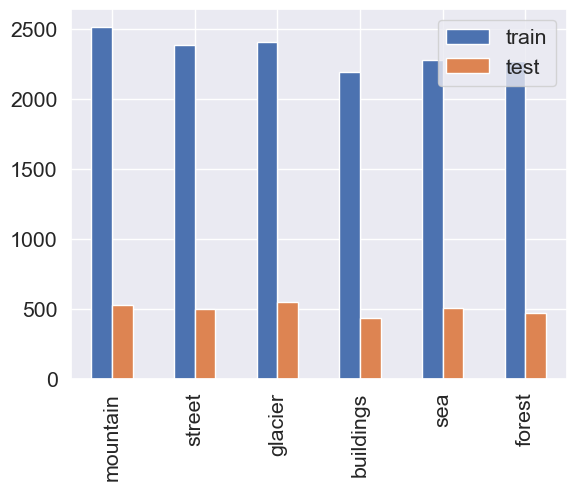

In [11]:
import pandas as pd

# Count each unique category's number of objects
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'test' : test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

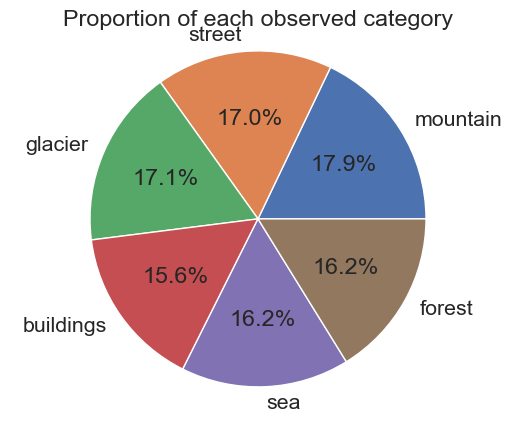

In [12]:
# Based on previously calculated values also create a piechart
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [13]:
# Scale down the pixel data to 0..1 range
train_images = train_images / 255.0 
test_images = test_images / 255.0

### 1.3.2 Visualization of our data

Display a random image from the images array and its correspond label from the labels array.


In [14]:
def display_random_image(class_names, images, labels):    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

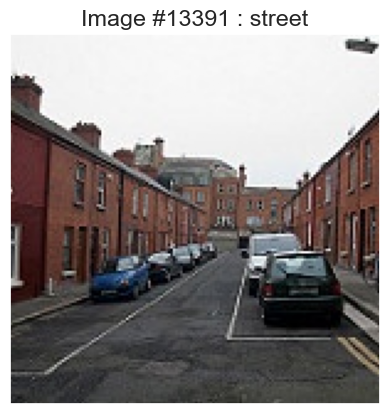

In [15]:
display_random_image(class_names, train_images, train_labels)


Display 25 images from the images array with its corresponding labels


In [16]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[index]])
    plt.show()

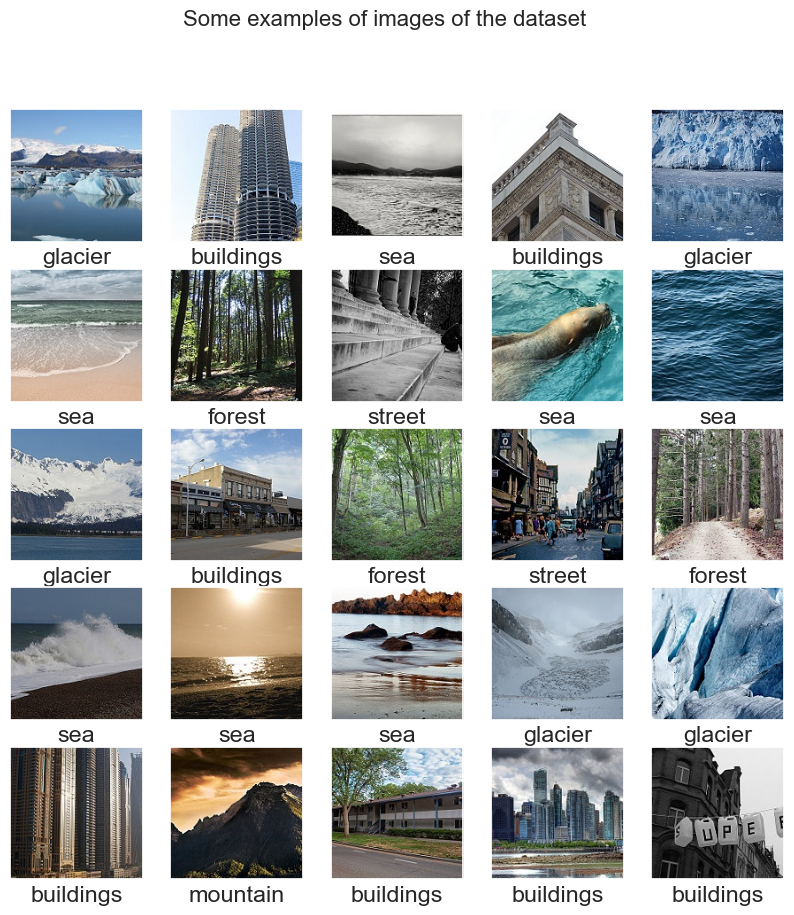

In [17]:
display_examples(class_names, train_images, train_labels)


#2. Simple Model Creation

Steps are:

1.   Build the model,
2.   Compile the model,
3.   Train / fit the data to the model,
4.   Evaluate the model on the testing set,
5.   Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:

- Conv2D: This layer extracts features by applying 32 filters of size 3x3 over the images.
- MaxPooling2D: This layer performs max pooling, which reduces the size of the input by taking the maximum value within each 2x2 region. Helps us retain essential features while reducing complexity of computations
- Flatten: This layer flattens the output of the previous layer into a 1D array, transforming the multi-dimensional feature maps into a linear representation.
- Relu: Given a value x, returns x if it's positive or else 0.
- Softmax: This layer is a fully connected layer with 6 neurons, representing the probability that the input image belongs to each of the 6 classes. The activation function used is softmax, which provides the probabilities of the different classes, ensuring that the predicted probabilities sum up to 1.

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

We will compile this model with these parameters:
- Optimizer='adam'=RMSProp + Momentum. Momentum takes into account past gradients that have better improvements. RMSProp is a root mean squared average of past gradients
- Loss function was chosen as such since its the standard value for classification where each image belongs only to one class


In [19]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Fit the model to the training set.

In [20]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(train_images, train_labels, 32)
test_gen = DataGenerator(test_images, test_labels, 32)


In [21]:
history = model.fit(train_gen, validation_data=test_gen, epochs=10)

Epoch 1/10
439/439 [==============================] - 11s 18ms/step - loss: 2.0289 - accuracy: 0.1772 - val_loss: 1.7908 - val_accuracy: 0.1750
Epoch 2/10
439/439 [==============================] - 7s 17ms/step - loss: 1.7001 - accuracy: 0.2604 - val_loss: 1.7373 - val_accuracy: 0.3183
Epoch 3/10
439/439 [==============================] - 7s 17ms/step - loss: 1.3542 - accuracy: 0.4599 - val_loss: 1.2107 - val_accuracy: 0.5263
Epoch 4/10
439/439 [==============================] - 8s 17ms/step - loss: 1.1839 - accuracy: 0.5473 - val_loss: 1.1658 - val_accuracy: 0.5387
Epoch 5/10
439/439 [==============================] - 8s 17ms/step - loss: 1.0185 - accuracy: 0.6096 - val_loss: 0.9789 - val_accuracy: 0.6317
Epoch 6/10
439/439 [==============================] - 8s 17ms/step - loss: 0.9223 - accuracy: 0.6408 - val_loss: 0.9934 - val_accuracy: 0.6310
Epoch 7/10
439/439 [==============================] - 8s 18ms/step - loss: 0.7148 - accuracy: 0.7271 - val_loss: 0.8999 - val_accuracy: 0.684

In [22]:
test_loss = model.evaluate(test_images, test_labels)


94/94 [==============================] - 1s 8ms/step - loss: 1.1677 - accuracy: 0.6690


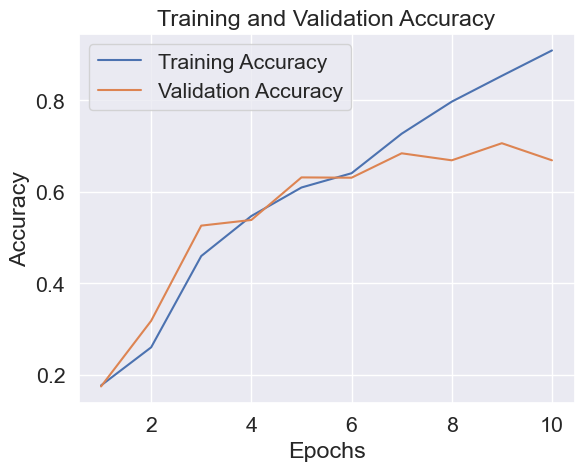

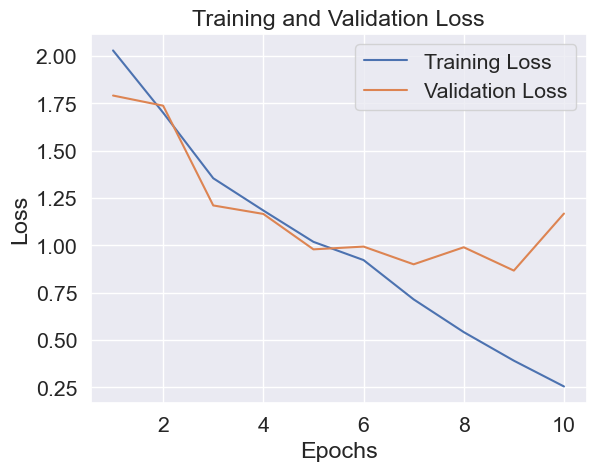

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()